## Descripción del proyecto

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

## Cargar datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Cargar datasets
Clients = pd.read_csv('/datasets/telecom_clients_us.csv')

Calls = pd.read_csv('/datasets/telecom_dataset_us.csv')

## Mostrar DataFrames

In [3]:
display('Datos llamadas:')
display(Calls.head())
display("Datos clientes:")
display(Clients.head())

'Datos llamadas:'

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


'Datos clientes:'

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


El DataFrame **Calls** contiene datos sobre el trafico de las llamadas en el callcenter CallMeMaybe y se conforma de 9 columnas.

El DataFrame **Clients** contiene datos sobre los clientes que realizan llamadas al callcenter CallMeMaybe y se conforma de 3 columnas.

In [4]:
Calls.info()
Clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2 

Las columas en el dataframe **Calls** son de cuatro tipos de datos int64, object, float64 y bool. Con respecto de las filas **Calls** contiene 53902 entradas.

Las columas en el dataframe **Clients** son de dos tipos de datos int64 y object. Con respecto de las filas **Clients** contiene 732 entradas.

## Convertir columnas a tipo adecuado

In [5]:
Calls['internal'] = Calls['internal'].astype('bool') # convertir a tipo bool
Calls['date'] = pd.to_datetime(Calls['date']).dt.tz_localize(None) # convertir a tipo fecha localizada
Clients['date_start'] = pd.to_datetime(Clients['date_start']) # convertir a tipo fecha

La columna 'internal' en **Calls** tiene unicamente datos True y False, pero es tipo object,  así que lo cambiaremos a tipo 'bool'.
La columna 'date' en **Calls** tiene datos de fecha y hora pero es tipo object,  así que lo cambiaremos a tipo 'fecha localizada'.
La columna 'date_satrt' en **Clients** tiene datos de fecha y hora pero es tipo object,  así que lo cambiaremos a tipo 'fecha'.

## Limpieza de datos: eliminar valores NaN

In [6]:
# Eliminar registros con valores NaN en el dataset de llamadas
df_calls_clean = Calls.dropna()
display(f"Número de registros después de eliminar NaN: {df_calls_clean.shape[0]}")

# Calcular tiempo de espera como diferencia entre total_call_duration y call_duration
df_calls_clean["waiting_time"] = df_calls_clean["total_call_duration"] - df_calls_clean["call_duration"]

# Realizar un resumen de las llamadas perdidas
missed_calls = df_calls_clean[df_calls_clean["is_missed_call"] == True]
display(f'Resumen de llamadas perdidas:')
display(missed_calls.describe())

'Número de registros después de eliminar NaN: 45730'

/tmp/ipykernel_371/570363844.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calls_clean["waiting_time"] = df_calls_clean["total_call_duration"] - df_calls_clean["call_duration"]


'Resumen de llamadas perdidas:'

,user_id,operator_id,calls_count,call_duration,total_call_duration,waiting_time
count,15518.000000,15518.000000,15518.000000,15518.000000,15518.000000,15518.000000
mean,167315.162843,916720.792241,19.308996,1.644800,449.359196,447.714396
std,618.660252,21947.334785,74.293160,21.599673,1553.567629,1553.867774
min,166377.000000,879896.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,900352.000000,1.000000,0.000000,19.250000,18.000000
50%,167175.000000,914433.000000,4.000000,0.000000,84.000000,80.000000
75%,167888.000000,937788.000000,14.000000,0.000000,331.000000,329.000000
max,168606.000000,973120.000000,4817.000000,741.000000,45312.000000,45312.000000


Eliminar del DataFrame **Calls** los registros NaN. 

Verificar del DataFrame **Calls** las llamadas perdidas con la columna is_missed_call.

In [7]:
# Eliminar registros anómalos
# 1. Llamadas realizadas por operadores que los clientes contestan pero duran nada:
#    => Si la llamada no es marcada como perdida pero call_duration == 0, se considera errónea.
df_calls_clean = df_calls_clean[~((df_calls_clean["is_missed_call"] == False) & (df_calls_clean["call_duration"] == 0))]

# 2. Eliminar llamadas con total_call_duration == 0 (ningún tiempo de llamada, se asume que no fue contestada)
df_calls_clean = df_calls_clean[df_calls_clean["total_call_duration"] > 0]

# 3. Eliminar duplicados en llamadas no perdidas
df_calls_clean = df_calls_clean.drop_duplicates(subset=[ "user_id", "date", "direction", "internal", "operator_id", "calls_count", "call_duration", "total_call_duration"])

display(f"Número de registros después de limpieza: {df_calls_clean.shape[0]}")

'Número de registros después de limpieza: 40668'

Se eliminaron registros con duración de llamada igual a 0 en situaciones anómalas. Se consideran “anómalas” aquellas llamadas que: Son realizadas por operadores y contestadas por clientes (o viceversa) pero tienen una duración de llamada (call_duration) igual a 0.

Se registran llamadas en las que ni el operador ni el cliente contestaron (por ejemplo, si además de ser llamada perdida se tienen tiempos de llamada no esperados).

Después de la limpieza quedan 40668 datos.

## Análisis exploratorio de datos (EDA):

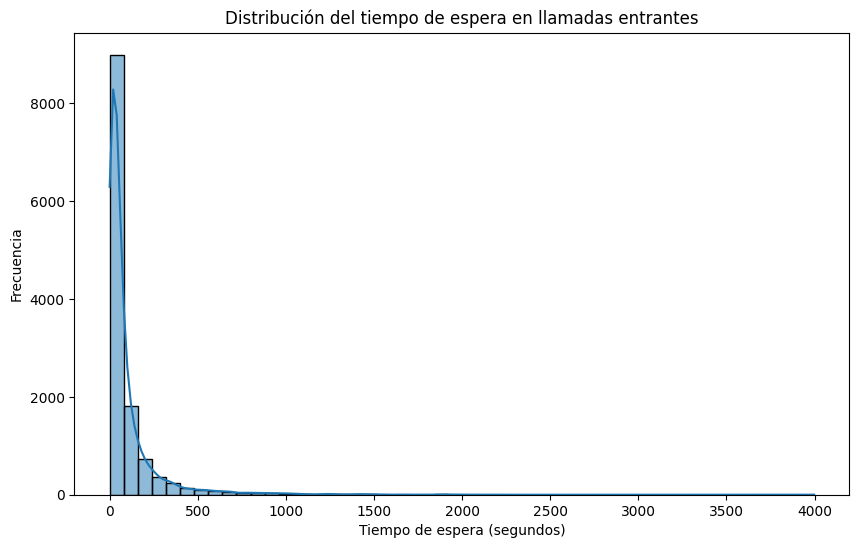

In [8]:
# Histograma del tiempo de espera total en llamadas entrantes
plt.figure(figsize=(10,6))
sns.histplot(df_calls_clean[df_calls_clean["direction"] == "in"]["total_call_duration"] - 
             df_calls_clean[df_calls_clean["direction"] == "in"]["call_duration"],
             bins=50, kde=True)
plt.title("Distribución del tiempo de espera en llamadas entrantes")
plt.xlabel("Tiempo de espera (segundos)")
plt.ylabel("Frecuencia")
plt.show()

En el gráfico anterior presenta la distribución sesgada a la derecha por lo tanto la mayoría de las llamadas tienen tiempos de espera cortos, concentrándose principalmente en el rango de 0 a 100 segundos, con un pico alrededor de 10 segundos.

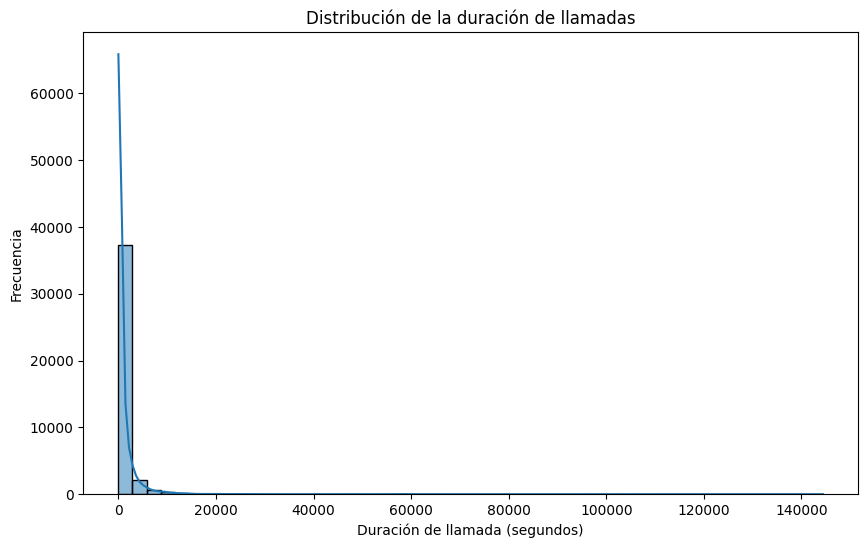

In [9]:
# Histograma de la duración de llamadas 
plt.figure(figsize=(10,6))
sns.histplot(df_calls_clean["call_duration"], bins=50, kde=True)
plt.title("Distribución de la duración de llamadas")
plt.xlabel("Duración de llamada (segundos)")
plt.ylabel("Frecuencia")
plt.show()

En el gráfico siguiente se observa que la mayoría de las llamadas duran poco tiempo (pico pronunciado al inicio). Hay una larga cola a la derecha, lo que indica que existen algunas llamadas muy largas (valores atípicos).

La distribución es sesgada positivamente, lo que es común en este tipo de datos.

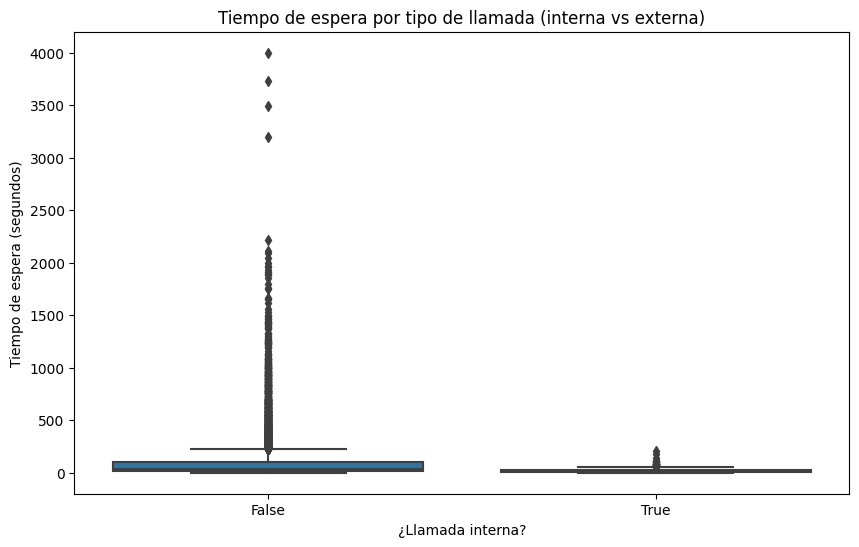

In [10]:
# Boxplot del tiempo de espera por tipo de llamada (interna, externa)
plt.figure(figsize=(10,6))
df_calls_clean["waiting_time"] = df_calls_clean["total_call_duration"] - df_calls_clean["call_duration"]
sns.boxplot(x="internal", y="waiting_time", data=df_calls_clean[df_calls_clean["direction"] == "in"])
plt.title("Tiempo de espera por tipo de llamada (interna vs externa)")
plt.xlabel("¿Llamada interna?")
plt.ylabel("Tiempo de espera (segundos)")
plt.show()

El gráfico muestra el tiempo de espera en segundos para dos tipos de llamadas: internas (True) y externas (False). Para las llamadas externas (False), presentan tiempos de espera significativamente más altos en comparación con las internas. Se observa una mayor dispersión en los datos, con valores atípicos que alcanzan tiempos elevados.

Llamadas internas (True): Muestran tiempos de espera mucho más bajos y una distribución más uniforme, lo que sugiere una gestión más eficiente de estas comunicaciones.

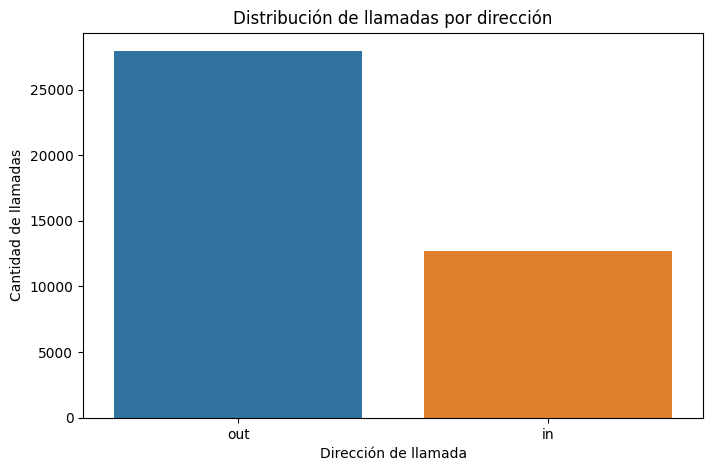

In [11]:
# Conteo de llamadas por dirección
plt.figure(figsize=(8,5))
sns.countplot(x="direction", data=df_calls_clean)
plt.title("Distribución de llamadas por dirección")
plt.xlabel("Dirección de llamada")
plt.ylabel("Cantidad de llamadas")
plt.show()

En el gráfico anterior se observa que se realizaron muchas más llamadas salientes que entrantes. Esto puede indicar que el sistema o los agentes hacen un mayor esfuerzo proactivo.

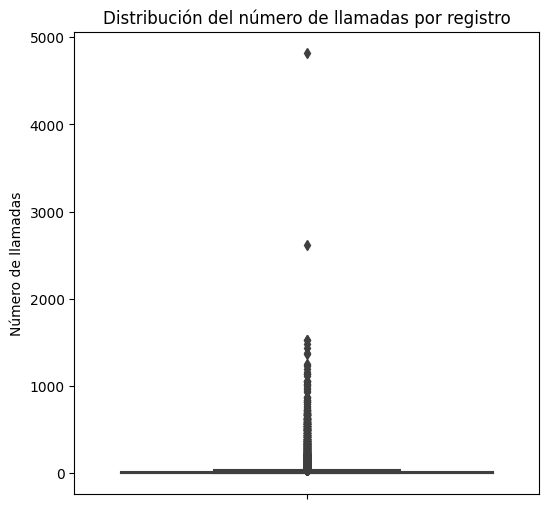

In [12]:
# Boxplot del número de llamadas por registro
plt.figure(figsize=(6,6))
sns.boxplot(y=df_calls_clean["calls_count"])
plt.title("Distribución del número de llamadas por registro")
plt.ylabel("Número de llamadas")
plt.show()

El gráfico de caja indica que la mayoría de los valores están concentrados en la parte inferior del gráfico, con un rango intercuartílico bastante estrecho, lo que indica que la mayoría de los registros tienen un número de llamadas relativamente bajo.

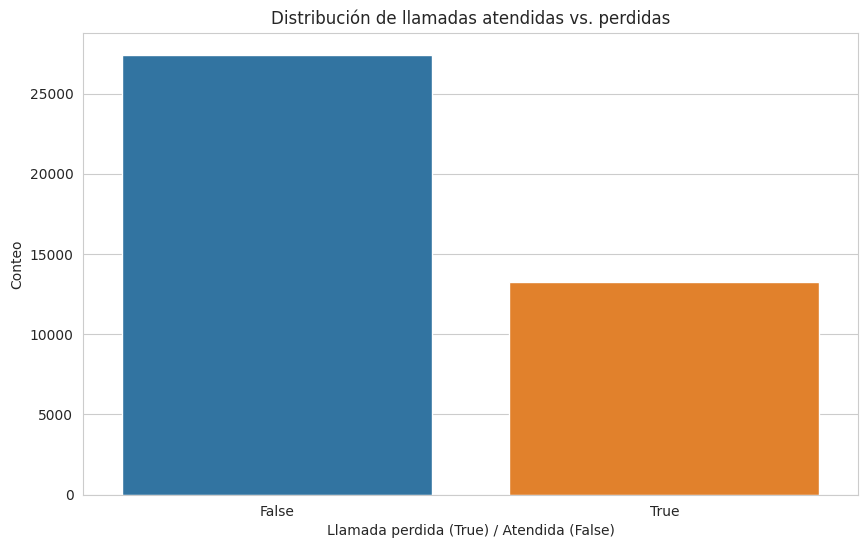

In [13]:
# Distribución de llamadas perdidas vs. atendidas
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.countplot(x="is_missed_call", data=df_calls_clean)
plt.title("Distribución de llamadas atendidas vs. perdidas")
plt.xlabel("Llamada perdida (True) / Atendida (False)")
plt.ylabel("Conteo")
plt.show()

Se observa que existen mas llamadas que estan siendo atendidas (False), pero el número de llamadas perdidas (True) aún es considerable.

Aunque es positivo que la mayoría de las llamadas se atiendan, la proporción de llamadas perdidas no es despreciable. Esto puede indicar cuellos de botella en determinados horarios, operadores sobrecargados o tiempos de espera prolongados que llevan a que el cliente abandone la llamada.

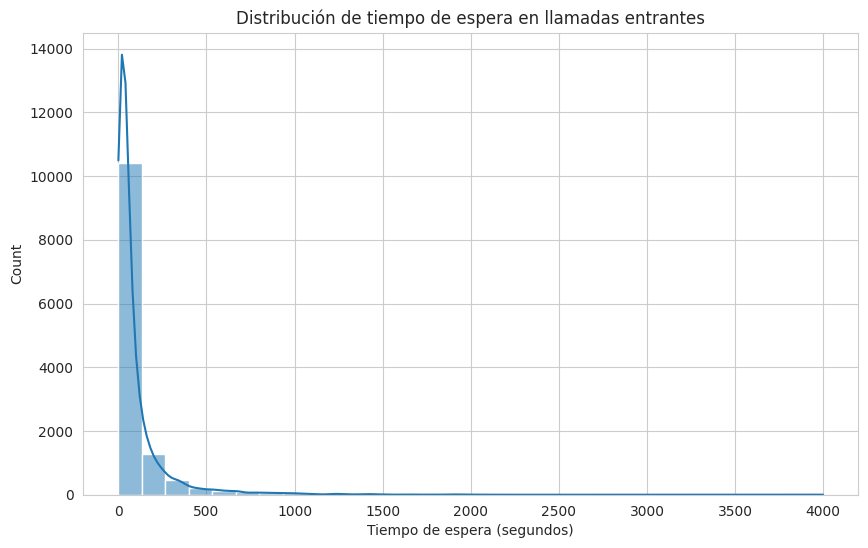

In [14]:
# Histograma de tiempos de espera en llamadas entrantes (direction = 'in')
df_incoming = df_calls_clean[df_calls_clean["direction"] == "in"]
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.histplot(df_incoming["waiting_time"], bins=30, kde=True)
plt.title("Distribución de tiempo de espera en llamadas entrantes")
plt.xlabel("Tiempo de espera (segundos)")
plt.show()

La gráfica muestra un comportamiento muy sesgado: la mayoría de las llamadas tienen un tiempo de espera relativamente bajo, se concentran cerca de 0 a 100 segundos.
La mayoría de las llamadas se atienden con un tiempo de espera aceptable, pero existe un conjunto de llamadas con esperas excesivamente largas.
La cola larga se puede deber a casos anómalos.

## Identificación de operadores ineficaces

Para cada operador se calcula:

    - Número total de llamadas entrantes (in)
    - Número total de llamadas perdidas (in)
    - Tiempo de espera promedio en llamadas entrantes
    - Número de llamadas salientes (out) (si corresponde)

Esto se reliza para poder tener las metricas necesarias para evaluar el rendimiento de cada operador

In [15]:
# Agregamos métricas para llamadas entrantes
incoming_metrics = df_calls_clean[df_calls_clean["direction"] == "in"].groupby("operator_id").agg({
    "calls_count": "sum",
    "is_missed_call": lambda x: np.sum(x == True),
    "waiting_time": "mean"
}).rename(columns={"calls_count": "total_incoming_calls", "is_missed_call": "total_missed_calls", "waiting_time": "avg_waiting_time"})

# Métricas para llamadas salientes 
outgoing_metrics = df_calls_clean[df_calls_clean["direction"] == "out"].groupby("operator_id").agg({
    "calls_count": "sum"
}).rename(columns={"calls_count": "total_outgoing_calls"})

# Unir ambas métricas
metrics = incoming_metrics.join(outgoing_metrics, how="outer").fillna(0)
metrics["missed_rate"] = metrics["total_missed_calls"] / metrics["total_incoming_calls"]
display("Métricas agregadas por operador:")
display(metrics.head())

'Métricas agregadas por operador:'

,total_incoming_calls,total_missed_calls,avg_waiting_time,total_outgoing_calls,missed_rate
operator_id,,,,,
879896.0,58.0,0.0,27.333333,870.0,0.0
879898.0,104.0,0.0,29.473684,7207.0,0.0
880020.0,7.0,0.0,7.714286,36.0,0.0
880022.0,8.0,0.0,14.000000,179.0,0.0
880026.0,24.0,0.0,7.944444,2194.0,0.0


Como se observa todos los operadores están atendiendo las llamadas entrantes, ya que no hay llamadas perdidas. Esto indica que, al menos en el periodo analizado, todos los operadores atendieron todas las llamadas entrantes sin dejar ninguna sin contestar.

Aunque no hay llamadas perdidas, el tiempo de espera varía entre los operadores, lo cual se evidencia la variabilidad en el tiempo de espera, lo que podría afectar la experiencia del cliente y señalar áreas para mejorar la eficiencia operativa. 

## Definir umbrales para identificar operadores ineficaces

Se utilizan los percentiles 75 (Q3) como umbrales porque permiten identificar a los operadores que están en el cuartil superior, es decir, los que tienen::
  - Las tasas de llamadas perdidas más altas (peor desempeño) 
  - Los tiempos de espera promedio más largos (mayor ineficiencia) 

Se utiliza para los operadores que están en el 25% con menos llamadas salientes, es decir, los menos activos o menos productivos en esa dimensión.
  - Si realizan llamadas salientes: cantidad inferior al percentil 25

In [16]:
umbral_missed = metrics["missed_rate"].quantile(0.75)
umbral_wait = metrics["avg_waiting_time"].quantile(0.75)
umbral_outgoing = metrics["total_outgoing_calls"].quantile(0.25)

print(f"\nUmbral tasa de perdidas (75th): {umbral_missed:.2f}")
print(f"Umbral tiempo de espera (75th): {umbral_wait:.2f} segundos")
print(f"Umbral llamadas salientes (25th): {umbral_outgoing}")

# Marcar operadores ineficaces según criterios
def es_ineficaz(row):
    # Condición 1: alta tasa de llamadas perdidas y alto tiempo de espera en llamadas entrantes
    cond1 = (row["missed_rate"] > umbral_missed) and (row["avg_waiting_time"] > umbral_wait)
    # Condición 2: si se espera que realice llamadas salientes, pero tiene pocas
    cond2 = (row["total_outgoing_calls"] < umbral_outgoing) if row["total_outgoing_calls"] > 0 or metrics["total_outgoing_calls"].sum() > 0 else False
    return cond1 or cond2

metrics["ineficaz"] = metrics.apply(es_ineficaz, axis=1)
print("\nOperadores ineficaces identificados:")
print(metrics[metrics["ineficaz"]].sort_values("missed_rate", ascending=False).head())


Umbral tasa de perdidas (75th): 0.01
Umbral tiempo de espera (75th): 43.00 segundos
Umbral llamadas salientes (25th): 1.0

Operadores ineficaces identificados:
             total_incoming_calls  total_missed_calls  avg_waiting_time  \
operator_id                                                               
913886.0                      2.0                 1.0             13.50   
934098.0                      6.0                 2.0             31.80   
910226.0                      8.0                 2.0             16.50   
930242.0                      4.0                 1.0             17.25   
919896.0                      5.0                 1.0             17.50   

             total_outgoing_calls  missed_rate  ineficaz  
operator_id                                               
913886.0                      0.0     0.500000      True  
934098.0                      0.0     0.333333      True  
910226.0                      0.0     0.250000      True  
930242.0          

De manera general estos resultados sugieren que, aunque el tiempo de espera de estos operadores no sea excesivamente alto, la combinación de una alta proporción de llamadas perdidas, y la falta total de actividad en llamadas salientes los clasifica como operadores ineficaces. Esto puede indicar problemas en la asignación de tareas o en la capacitación para manejar llamadas de forma proactiva, lo cual es crítico en un entorno donde se espera una alta eficiencia en la atención y salida de llamadas.

## Prueba de hipótesis estadística

Hipótesis:
   H0: No existe diferencia en el tiempo de espera promedio entre operadores eficaces e ineficaces.
   H1: Los operadores ineficaces tienen un tiempo de espera promedio mayor que los eficaces.

In [17]:
# Crear dos grupos
ineficaces = metrics[metrics["ineficaz"]]["avg_waiting_time"]
eficaces = metrics[~metrics["ineficaz"]]["avg_waiting_time"]

# Realizar el t-test de una cola (ya que H1 indica que los ineficaces tienen mayor tiempo de espera)
t_stat, p_value = stats.ttest_ind(ineficaces, eficaces, alternative="greater")
print(f"T-test: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

if p_value < 0.05:
    print("Se rechaza H0: hay evidencia significativa de que los operadores ineficaces tienen tiempos de espera mayores.")
else:
    print("No se rechaza H0: no se observa diferencia significativa en el tiempo de espera.")

T-test: t-statistic = 4.281, p-value = 0.000
Se rechaza H0: hay evidencia significativa de que los operadores ineficaces tienen tiempos de espera mayores.


Se rechaza la hipótesis nula (H0) y se acepta la hipótesis alternativa (H1), lo que significa que existe evidencia estadísticamente significativa de que los operadores ineficaces tienen un tiempo de espera promedio mayor que los operadores eficaces. Esto respalda la idea de que el tiempo de espera es un buen indicador para diferenciar entre operadores con buen y mal desempeño.

## Conclusiones generales

Identificación de ineficacia:
Se encontró que los operadores con una tasa elevada de llamadas perdidas y tiempos de espera prolongados en las llamadas entrantes son, en general, los más ineficaces. Además, para aquellos operadores que también deben realizar llamadas salientes, un volumen significativamente bajo en estas llamadas indica problemas en su desempeño.

Impacto en la calidad del servicio:
Los altos tiempos de espera y la elevada tasa de llamadas perdidas pueden generar una experiencia de usuario negativa, afectando la satisfacción de los clientes y, en consecuencia, la reputación del servicio de telefonía virtual.

Soporte estadístico:
La prueba de hipótesis (por ejemplo, el t-test) respalda la idea de que los operadores ineficaces presentan tiempos de espera significativamente mayores, lo cual refuerza la validez de la clasificación basada en las métricas analizadas.

Otros aspectos:
Todos los operadores han atendido el 100% de las llamadas entrantes.
No hay ninguna llamada perdida, por lo tanto, la tasa de pérdida es 0, lo cual es ideal.
Aunque hay diferencias (7 a 29 seg) en el tiempo de espera, ninguno supera umbrales críticos.

## Mejoras

Revisión y entrenamiento:
Se sugiere revisar el protocolo de manejo de llamadas y mejorar el entrenamiento de los operadores para optimizar su respuesta y reducir la tasa de llamadas perdidas.

Optimización de la distribución de llamadas:
Ajustar la distribución de llamadas entrantes para evitar sobrecargar a ciertos operadores, lo que podría contribuir a reducir los tiempos de espera y mejorar la eficiencia general.

Alertas tempranas:
Implementar un sistema de alertas que notifique de forma inmediata cuando se superen umbrales críticos en términos de tiempos de espera o tasas de llamadas perdidas. Esto permitiría intervenir antes de que la ineficacia se traduzca en una mala experiencia para los clientes.

Segmentación adicional:
Profundizar en el análisis segmentando por tipos de cliente o tarifas, ya que podría haber patrones o necesidades específicas que varíen según el segmento, lo cual ayudaría a personalizar las estrategias de mejora.

Reevaluación de umbrales:
Considerar la posibilidad de ajustar los umbrales utilizados (percentiles 75 para perdidas y tiempos, 25 para llamadas salientes) según el comportamiento observado en los datos reales, lo que permitirá una identificación más precisa de los operadores ineficaces.